In [1]:
## Imports #########################################################################
from keras.datasets.fashion_mnist import load_data
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot
from numpy import *
from numpy.random import randn
from numpy.random import randint

In [2]:
## Define Models ######################################################################### 

## Discriminator ##
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 1))(li)
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

## Generator ##
def define_generator(latent_dim, n_classes=10):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

## cGAN ##
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
## Define Functions #########################################################################

## Helper Functions ##
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return [X, trainy]

def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    print(labels.shape)
    print(labels)
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

## Train ##
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # save the generator model
    g_model.save('cgan_generator.h5')

In [7]:
## Running Training #########################################################################

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

(60000,)
[9 0 0 ... 3 0 5]
>1, 1/468, d1=0.688, d2=0.695 g=0.692
(60000,)
[9 0 0 ... 3 0 5]
>1, 2/468, d1=0.621, d2=0.700 g=0.687
(60000,)
[9 0 0 ... 3 0 5]
>1, 3/468, d1=0.546, d2=0.710 g=0.676
(60000,)
[9 0 0 ... 3 0 5]
>1, 4/468, d1=0.497, d2=0.730 g=0.660
(60000,)
[9 0 0 ... 3 0 5]
>1, 5/468, d1=0.461, d2=0.755 g=0.639
(60000,)
[9 0 0 ... 3 0 5]
>1, 6/468, d1=0.405, d2=0.789 g=0.614
(60000,)
[9 0 0 ... 3 0 5]
>1, 7/468, d1=0.364, d2=0.830 g=0.593
(60000,)
[9 0 0 ... 3 0 5]
>1, 8/468, d1=0.341, d2=0.861 g=0.588
(60000,)
[9 0 0 ... 3 0 5]
>1, 9/468, d1=0.321, d2=0.857 g=0.602
(60000,)
[9 0 0 ... 3 0 5]
>1, 10/468, d1=0.323, d2=0.809 g=0.644
(60000,)
[9 0 0 ... 3 0 5]
>1, 11/468, d1=0.302, d2=0.756 g=0.721
(60000,)
[9 0 0 ... 3 0 5]
>1, 12/468, d1=0.322, d2=0.655 g=0.825
(60000,)
[9 0 0 ... 3 0 5]
>1, 13/468, d1=0.343, d2=0.572 g=0.946
(60000,)
[9 0 0 ... 3 0 5]
>1, 14/468, d1=0.330, d2=0.483 g=1.062
(60000,)
[9 0 0 ... 3 0 5]
>1, 15/468, d1=0.330, d2=0.437 g=1.141
(60000,)
[9 0 0 ...

Exception ignored in: <function ScopedTFGraph.__del__ at 0x7fa2123e3280>
Traceback (most recent call last):
  File "/usr/local/share/anaconda3/envs/ewu-dmls/lib/python3.8/site-packages/tensorflow/python/framework/c_api_util.py", line 54, in __del__
    self.deleter(self.graph)
KeyboardInterrupt: 


>1, 26/468, d1=0.145, d2=1.016 g=0.619
(60000,)
[9 0 0 ... 3 0 5]
>1, 27/468, d1=0.138, d2=0.702 g=0.876
(60000,)
[9 0 0 ... 3 0 5]
>1, 28/468, d1=0.121, d2=0.477 g=1.192
(60000,)
[9 0 0 ... 3 0 5]
>1, 29/468, d1=0.110, d2=0.378 g=1.363
(60000,)
[9 0 0 ... 3 0 5]
>1, 30/468, d1=0.095, d2=0.364 g=1.281
(60000,)
[9 0 0 ... 3 0 5]
>1, 31/468, d1=0.078, d2=0.420 g=1.117
(60000,)
[9 0 0 ... 3 0 5]
>1, 32/468, d1=0.078, d2=0.489 g=0.975
(60000,)
[9 0 0 ... 3 0 5]
>1, 33/468, d1=0.074, d2=0.554 g=0.871
(60000,)
[9 0 0 ... 3 0 5]
>1, 34/468, d1=0.059, d2=0.605 g=0.800
(60000,)
[9 0 0 ... 3 0 5]
>1, 35/468, d1=0.072, d2=0.646 g=0.752
(60000,)
[9 0 0 ... 3 0 5]
>1, 36/468, d1=0.058, d2=0.696 g=0.704
(60000,)
[9 0 0 ... 3 0 5]
>1, 37/468, d1=0.034, d2=0.754 g=0.652
(60000,)
[9 0 0 ... 3 0 5]
>1, 38/468, d1=0.031, d2=0.815 g=0.604
(60000,)
[9 0 0 ... 3 0 5]
>1, 39/468, d1=0.066, d2=0.877 g=0.562
(60000,)
[9 0 0 ... 3 0 5]
>1, 40/468, d1=0.049, d2=0.949 g=0.535
(60000,)
[9 0 0 ... 3 0 5]
>1, 41/468

KeyboardInterrupt: 

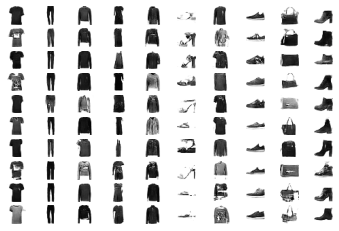

In [5]:
## Loading Model/Generating Data #########################################################################

## Functions ##
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()
    
## Execution ##
# load model
model = load_model('Models/cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)